<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/07_external_validity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
data = pd.read_csv('/content/external_validity_homework_2.csv', parse_dates=['date_in_app', 'first_date_in_app'])
data

,user_id,sample_type,date_in_app,first_date_in_app,day_of_test,conv_to_contact_daily
0,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-02,2023-07-02,22,0
1,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-06,2023-07-02,26,0
2,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-08,2023-07-02,28,0
3,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-09,2023-07-02,29,0
4,00027C4F85D64F4A81E95ECCCA1634FE,B,2023-06-14,2023-06-14,4,0
...,...,...,...,...,...,...
713951,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-04,2023-06-28,24,1
713952,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-03,2023-06-28,23,1
713953,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-05,2023-06-28,25,1
713954,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-08,2023-06-28,28,1


# Кейс 1. Эффект новизны #
## Задание 1. Проведение первичного теста (1/3) ##
Укажите разницу конверсий в группе B и A

Введите значение в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
# В каждой группе выделим пользователей у которых были конверсии в период теста
user_conv_df = data.groupby(['sample_type', 'user_id']).conv_to_contact_daily.max()
user_conv_df

sample_type  user_id                         
A            00018D9EB5E146AA8B578E427AEC323A    0
             000583A79EFB433FB27EF71B3A310B1A    1
             000662BD871743EC9FD1A03E52B040F2    1
             0006A619E49047099E9B94880E2B6771    1
             00072C87F9AF483795456F4CDEC20993    1
                                                ..
B            FFF075238BFF41A69F1C3E4584B2C548    1
             FFF3D2CA02084490BFA253F0C91740D2    0
             FFF503AB87C44E61B345B95842D9B98F    0
             FFF5D2BB4F4C45DB8CE54A1F4BD1A4F2    1
             FFF70A5A2D15460E9771AD0D5D4D80BC    1
Name: conv_to_contact_daily, Length: 97041, dtype: int64

In [ ]:
print(f"Разница конверсий в группе B и A составляет {user_conv_df.groupby('sample_type').mean().diff()['B'].round(3)}")

Разница конверсий в группе B и A составляет -0.014


## Задание 1. Проведение первичного теста (2/3) ##


Проверьте с помощью двустороннего z-test на пропорцию долю в каждой из групп. И укажите z-статистику, полученную в тесте.

Введите значение в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
gr_a = user_conv_df["A"]
gr_b = user_conv_df["B"]
z_stat = proportions_ztest([gr_a.sum(), gr_b.sum()], [gr_a.count(), gr_b.count()])[0]

In [ ]:
print(f'z-статистика {z_stat:.1f}')

z-статистика 6.4


## Задание 1. Проведение первичного теста (3/3) ##


Отвергается ли гипотеза H0 о равенстве долей в z-test из предыдущего степа на уровне значимости 0.05?

In [ ]:
alpha = 0.05
p_val = proportions_ztest([gr_a.sum(), gr_b.sum()], [gr_a.count(), gr_b.count()])[1]
print("Отвергаеаем H0 о равенстве долей в группах" if p_val < alpha else "Отвергнуть H0 о равенстве долей в группах нельзя")

Отвергаеаем H0 о равенстве долей в группах


## Задание 2. Проверка на сопротивление новому в тесте (1/5) ##


После первичного теста надо проверить есть ли эффект сопротивления новому в тесте.

Для этого вам необходимо будет снова доработать исходный датасет. А именно понять, кто в конкретный день новый в приложении, а кто уже "старый". Возьмем за правило, что "старым" пользователь становится, если он пришел три или больше дней назад.

Рассчитайте retention_day для каждого пользователя, т.е. разницу между днем в приложении (`date_in_app`) и первым днем в приложении (`first_date_in_app`)
Промаркируйте "старых" и новых пользователей в каждом дне
Постройте график конверсий по дням теста для 4 групп:

* новые пользователи — группа А
* новые пользователи — группа B
* старые пользователи — группа А
*старые пользователи — группа B
Постройте график эффектов между А и B для новых пользователей и старых пользователей.

У какой группы просела конверсия в начале теста?

In [ ]:
data['retention_day'] = (data['date_in_app'] - data['first_date_in_app']).dt.days
data['user_type'] = np.where(data['retention_day'] < 3, 'new', 'old')
data

,user_id,sample_type,date_in_app,first_date_in_app,day_of_test,conv_to_contact_daily,retention_day,user_type
0,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-02,2023-07-02,22,0,0,new
1,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-06,2023-07-02,26,0,4,old
2,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-08,2023-07-02,28,0,6,old
3,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-09,2023-07-02,29,0,7,old
4,00027C4F85D64F4A81E95ECCCA1634FE,B,2023-06-14,2023-06-14,4,0,0,new
...,...,...,...,...,...,...,...,...
713951,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-04,2023-06-28,24,1,6,old
713952,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-03,2023-06-28,23,1,5,old
713953,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-05,2023-06-28,25,1,7,old
713954,FFFE37BB811E410F9617079E4F74CB8A,A,2023-07-08,2023-06-28,28,1,10,old


In [ ]:
data_plot = data.groupby(['day_of_test', 'user_type', 'sample_type'], as_index=False).conv_to_contact_daily.mean()
data_plot

,day_of_test,user_type,sample_type,conv_to_contact_daily
0,0,new,A,0.737179
1,0,new,B,0.780120
2,0,old,A,0.800818
3,0,old,B,0.355381
4,1,new,A,0.732308
...,...,...,...,...
115,28,old,B,0.796829
116,29,new,A,0.728097
117,29,new,B,0.778846
118,29,old,A,0.828337


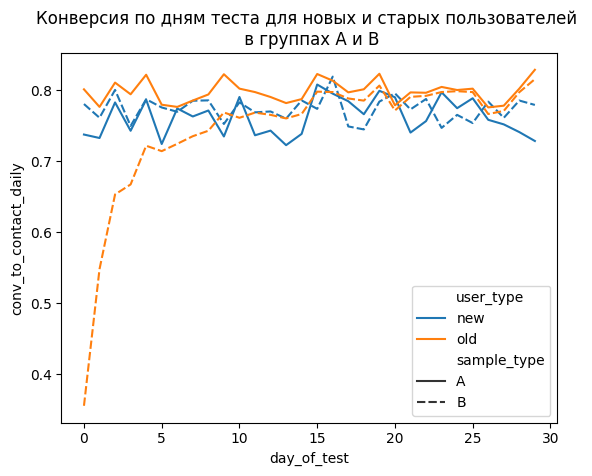

In [ ]:
sns.lineplot(data=data_plot, x='day_of_test', y='conv_to_contact_daily', hue='user_type', style='sample_type').\
set_title('Конверсия по дням теста для новых и старых пользователей \n в группах A и B');

## Задание 2. Проверка на сопротивление новому в тесте (2/5) ##


Рассчитайте среднедневную долю новых пользователей по дням теста (какую долю новые пользователи занимают в дневном трафике в среднем за период теста)

Введите значение в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
df = data.groupby(['day_of_test', 'user_type']).user_id.nunique().unstack()

<Axes: xlabel='day_of_test'>

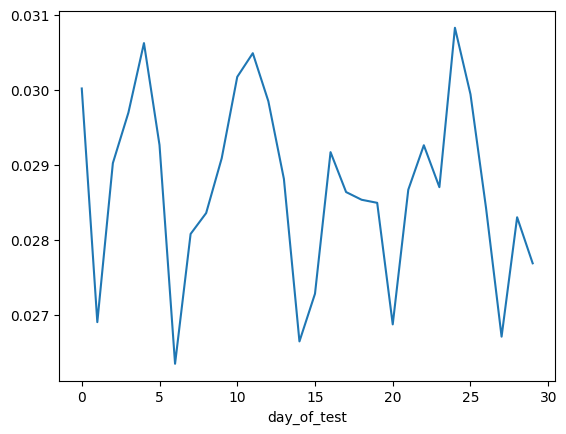

In [ ]:
df['ratio_new'] = df['new'] / (df['old'] + df['new'])
df.ratio_new.plot()

In [ ]:
print(f"Доля новых пользователей в дневном трафике в среднем за период теста {df.ratio_new.mean():.3f}")

Доля новых пользователей в дневном трафике в среднем за период теста 0.029


## Задание 2. Проверка на сопротивление новому в тесте (3/5) ##


Какое абсолютное значение разницы относительных эффектов на конверсию между "старой" группой и новой группой на 3 день теста (day_of_test == 2) ('conv_deltas_delta')?

Для расчета разницы эффектов нам нужно рассчитать несколько вариантов эффекта:

* Относительный эффект между А и Б группой для "старых" пользователей ('conv_delta_old')
* Относительный эффект между А и Б группой для новых пользователей ('conv_delta_new')
* Разницу между относительным эффектом в "старой" группе и таким же эффектом в "новой" группе ('conv_deltas_delta' = 'conv_delta_new' - 'conv_delta_old')

Введите значение в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
data_plot.query('day_of_test == 2').groupby(['sample_type', 'user_type']).conv_to_contact_daily.mean().unstack().pct_change(). \
diff(axis=1, periods=-1).round(3)

user_type,new,old
sample_type,,
A,NaN,NaN
B,0.217,NaN


## Задание 2. Проверка на сопротивление новому в тесте (4/5)  ##


Посчитайте, на какой день теста разница эффектов между "новой" группой и "старой" группой пользователей первый раз становится отрицательной.

In [ ]:
pivot = data_plot.pivot(index='day_of_test', columns=['user_type',	'sample_type'], values='conv_to_contact_daily')

In [ ]:
pivot.columns = [n[0] + n[1] for n in pivot.columns.to_flat_index()]

In [ ]:
#pivot['abs_delta'] = np.vectorize(lambda nA, nB, oA, oB: (nB/nA - 1) - (oB/oA - 1) )(*[pivot[name] for name in pivot.columns])
pivot['conv_delta_new'] = pivot['newB'] / pivot['newA'] - 1
pivot['conv_delta_old'] = pivot['oldB'] / pivot['oldA'] - 1
pivot['conv_deltas_delta'] = pivot['conv_delta_new'] - pivot['conv_delta_old']

In [ ]:
pivot.loc[pivot['conv_deltas_delta'] < 0].index[0]

15

## Задание 2. Проверка на сопротивление новому в тесте (5/5) ##


Есть ли эффект сопротивления новому?

In [ ]:
pivot.head()

,newA,newB,oldA,oldB,conv_delta_new,conv_delta_old,conv_deltas_delta
day_of_test,,,,,,,
0,0.737179,0.780120,0.800818,0.355381,0.058250,-0.556228,0.614478
1,0.732308,0.760797,0.776104,0.547733,0.038904,-0.294253,0.333157
2,0.782369,0.800000,0.810289,0.652883,0.022535,-0.194259,0.216795
3,0.742500,0.749271,0.793848,0.666943,0.009119,-0.159860,0.168980
4,0.786325,0.786885,0.821354,0.721421,0.000713,-0.121668,0.122381


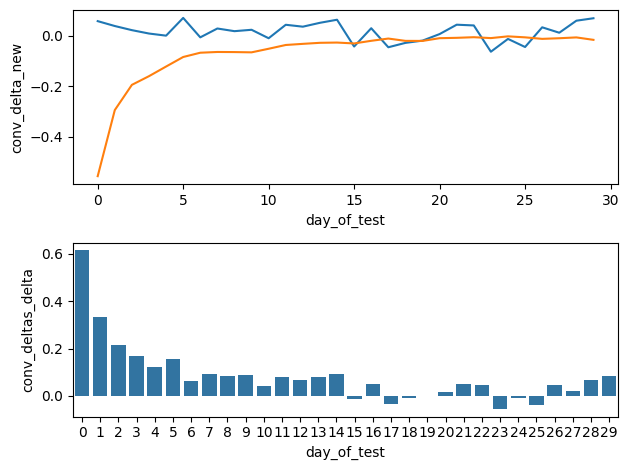

In [ ]:
fig, axes = plt.subplots(2, 1)
ax1 = sns.lineplot(data=pivot, x='day_of_test', y='conv_delta_new', ax=axes[0])
ax2 = sns.lineplot(data=pivot, x='day_of_test', y='conv_delta_old', ax=axes[0])
ax3 = sns.barplot(data=pivot, x='day_of_test', y='conv_deltas_delta', ax=axes[1])
plt.tight_layout()

Как видно на графике выше в данных точно присутствует эффект сопротивления новому, т.к. в группе старых пользователей эффект во времени не стабилен и отрицателен в начале теста, но со временем негативный эффект пропадает.

# Кейс 2. Эффект новизны #


## Задание 3. Проведение первичного теста (1/3) ##


Прежде всего надо провести тест на долю контактирующих в продукте и проверить, есть ли у нас статистически значимый рост конверсии.

Но нам также нужно сначала преобразовать дневной датасет в датасет, сагрегированный за весь период на уровне пользователя. Так же, как мы делали для проведения z-test в предыдущем кейсе.

Укажите разницу конверсий в группе B и A.

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [ ]:
data = pd.read_csv('/content/novelty_effect_homework_2.csv', parse_dates=['date_in_app', 'first_date_in_app'])
data.head()

,user_id,sample_type,date_in_app,total_contacts,first_date_in_app,day_of_test,conv_to_contact_daily
0,000015E6362C47CFBA851EA91D417F8B,A,2023-06-10,1.0,2023-01-12,0,1
1,000015E6362C47CFBA851EA91D417F8B,A,2023-06-29,5.0,2023-01-12,19,1
2,0000FF6D0FAE419384034F249C4DC10B,B,2023-06-22,1.0,2023-01-02,12,1
3,0000FF6D0FAE419384034F249C4DC10B,B,2023-06-18,10.0,2023-01-02,8,1
4,00028A57EC044DA2ADD1F07F93296838,A,2023-07-04,1.0,2023-01-16,24,1


In [ ]:
df_agg = data.groupby(['user_id', 'sample_type']).conv_to_contact_daily.max().reset_index()
df_agg.head()

,user_id,sample_type,conv_to_contact_daily
0,000015E6362C47CFBA851EA91D417F8B,A,1
1,0000FF6D0FAE419384034F249C4DC10B,B,1
2,00028A57EC044DA2ADD1F07F93296838,A,1
3,00028EA31D6D43E79DE5F9117DB7EE67,A,1
4,00039480581B409C96E9B8D979C06000,B,1


In [ ]:
df_agg.sample_type.value_counts()

sample_type
B    58459
A    58323
Name: count, dtype: int64

In [ ]:
print('разница конверсий в группе B и A', round(df_agg.groupby('sample_type').conv_to_contact_daily.mean().diff()[1],3))

разница конверсий в группе B и A 0.011


## Задание 3. Проведение первичного теста (2/3) ##


Проверим так же, как и в первом кейсе с сопротивлением новому, с помощью z-test на пропорцию долю в каждой из групп. И укажите значение z-статистики.

Введите значение в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
gr_a = df_agg.query('sample_type == "A"')['conv_to_contact_daily']
gr_b = df_agg.query('sample_type == "B"')['conv_to_contact_daily']
z_stat = proportions_ztest([gr_a.sum(), gr_b.sum()], [gr_a.count(), gr_b.count()])[0]
print("значение z-статистики", round(z_stat, 1))

значение z-статистики -6.0


## Задание 3. Проведение первичного теста (3/3) ##
Отвергается ли гипотеза H0 о равенстве долей в z-test из предыдущего степа на уровне значимости 0.05?


In [ ]:
print("p-value=", pval:=proportions_ztest([gr_a.sum(), gr_b.sum()], [gr_a.count(), gr_b.count()])[1], "H0 отвергается" if pval < 0.05 else "H0 не отвергается")

p-value= 2.2119390502818773e-09 H0 отвергается


## Задание 4. Проверка на присутствие эффекта новизны (1/3) ##

Для детекции эффекта новизны будем использовать алгоритм команды Linkedin, который мы рассматривали в видеоуроке. Вам нужно:

* Построить агрегированную таблицу по дням теста с конверсией в группе А и группе В
* Найти разницу в конверсиях (delta). Наш target в линейной регрессии
* Построить график и визуально проверить есть ли эффект новизны в данных
* Трансформировать метрику день теста (day_of_test) также как показано было в видеоуроке
* Обучить линейную регрессию
* Рассчитать R2
* Дать ответ, присутствует ли здесь эффект новизны.

In [ ]:
dayly_agg = data.groupby(['day_of_test', 'sample_type']).conv_to_contact_daily.mean().unstack()
dayly_agg['delta'] = dayly_agg.diff(axis=1)['B']

In [ ]:
dayly_agg.head()

sample_type,A,B,delta
day_of_test,,,
0,0.801359,0.913524,0.112166
1,0.774500,0.849515,0.075015
2,0.812389,0.850587,0.038198
3,0.789817,0.821426,0.031609
4,0.811692,0.832643,0.020951


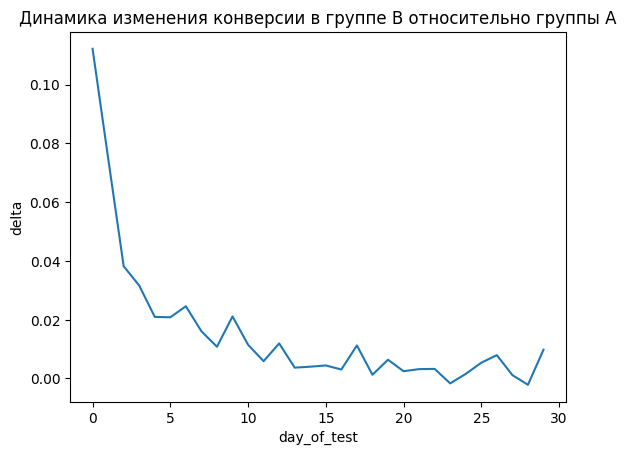

In [ ]:
sns.lineplot(data=dayly_agg, x='day_of_test', y='delta'). \
set_title('Динамика изменения конверсии в группе В относительно группы А');

Вероятно наблюдается эффект новизны

In [ ]:
dayly_agg.head()

sample_type,A,B,delta
day_of_test,,,
0,0.801359,0.913524,0.112166
1,0.774500,0.849515,0.075015
2,0.812389,0.850587,0.038198
3,0.789817,0.821426,0.031609
4,0.811692,0.832643,0.020951


In [ ]:
# Устанавливаем значения коэфициентов регрессии
alpha = 0.35
gamma = 2
dayly_agg['d_1'] = 1 / (dayly_agg.index + 1)**alpha
dayly_agg['d_2'] = 1 / (dayly_agg.index + 1)**gamma

In [ ]:
dayly_agg.head()

sample_type,A,B,delta,d_1,d_2
day_of_test,,,,,
0,0.801359,0.913524,0.112166,1.000000,1.000000
1,0.774500,0.849515,0.075015,0.784584,0.250000
2,0.812389,0.850587,0.038198,0.680781,0.111111
3,0.789817,0.821426,0.031609,0.615572,0.062500
4,0.811692,0.832643,0.020951,0.569325,0.040000


In [ ]:
X = dayly_agg[['d_1', 'd_2']]
Y = dayly_agg['delta']
model = LinearRegression(fit_intercept = True).fit(X, Y)

In [ ]:
dayly_agg['conv_prediced'] = model.predict(X)

<Axes: xlabel='day_of_test'>

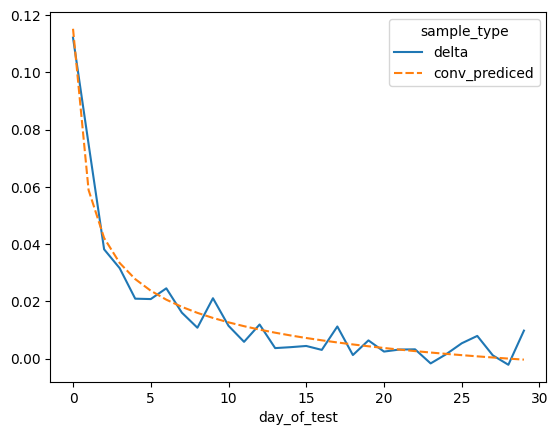

In [ ]:
sns.lineplot(dayly_agg[['delta', 'conv_prediced']])

## Задание 4. Проверка на присутствие эффекта новизны (2/3) ##


Укажите значение R^2 в полученном уравнении регрессии.

Введите значение в поле ниже с точностью до двух знаков в десятичной части.

In [ ]:
print(f"R^2 = {r2_score(Y, dayly_agg['conv_prediced']):.2f}")

R^2 = 0.95


In [ ]:
import statsmodels.api as sm

In [ ]:
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(Y, X).fit()

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     273.1
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.22e-18
Time:                        20:58:14   Log-Likelihood:                 115.84
No. Observations:                  30   AIC:                            -225.7
Df Residuals:                      27   BIC:                            -221.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0306      0.004     -6.868      0.0

In [ ]:
X

sample_type,d_1,d_2
day_of_test,,
0,1.000000,1.000000
1,0.784584,0.250000
2,0.680781,0.111111
3,0.615572,0.062500
4,0.569325,0.040000
5,0.534130,0.027778
6,0.506076,0.020408
7,0.482968,0.015625
8,0.463463,0.012346


## Задание 4. Проверка на присутствие эффекта новизны (3/3) ##


Присутствует ли эффект новизны?

In [ ]:
new_df = pd.read_csv('external_validity_homework_2.csv')

In [ ]:
# conv_to_contact_daily - дневная конверсия. А нам нужно найти ее максимальное значение за весь период теста
user_conv_df = new_df.groupby(['user_id', 'sample_type']).max().reset_index()


In [ ]:
conv_a = user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'A'].mean()
conv_b = user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'B'].mean()
conv_lift = conv_b - conv_a
print('Разница конверсии В к группе А составила', round(conv_lift, 3))


Разница конверсии В к группе А составила -0.014


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# посчитаем кол-во пользователей попавших в группу А и Б (nobs)
# посчитаем кол-во пользователей с хотя бы одной конверсией за период теста (counts)
nobs_a = user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'A'].count()
nobs_b = user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'B'].count()

count_a = (user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'A'] > 0).sum()
count_b = (user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'B'] > 0).sum()

# Применим двусторонний z-test для пропорции для проверки. Найдем z-статистику из теста
Z_stat = proportions_ztest([count_a, count_b], [nobs_a, nobs_b], alternative='two-sided')[0]

print('z-stat проверки через двусторонний z-test составил ', round(Z_stat, 1))


z-stat проверки через двусторонний z-test составил  6.4


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# посчитаем кол-во пользователей попавших в группу А и Б (nobs)
# посчитаем кол-во пользователей с хотя бы одной конверсией за период теста (counts)
nobs_a = user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'A'].count()
nobs_b = user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'B'].count()

count_a = (user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'A'] > 0).sum()
count_b = (user_conv_df['conv_to_contact_daily'][user_conv_df['sample_type'] == 'B'] > 0).sum()



print("Отвергается ли гипотеза о равенстве долей на уровне значимости 0.05? ->", proportions_ztest([count_a, count_b], [nobs_a, nobs_b], alternative='two-sided')[1] < 0.05)


Отвергается ли гипотеза о равенстве долей на уровне значимости 0.05? -> True


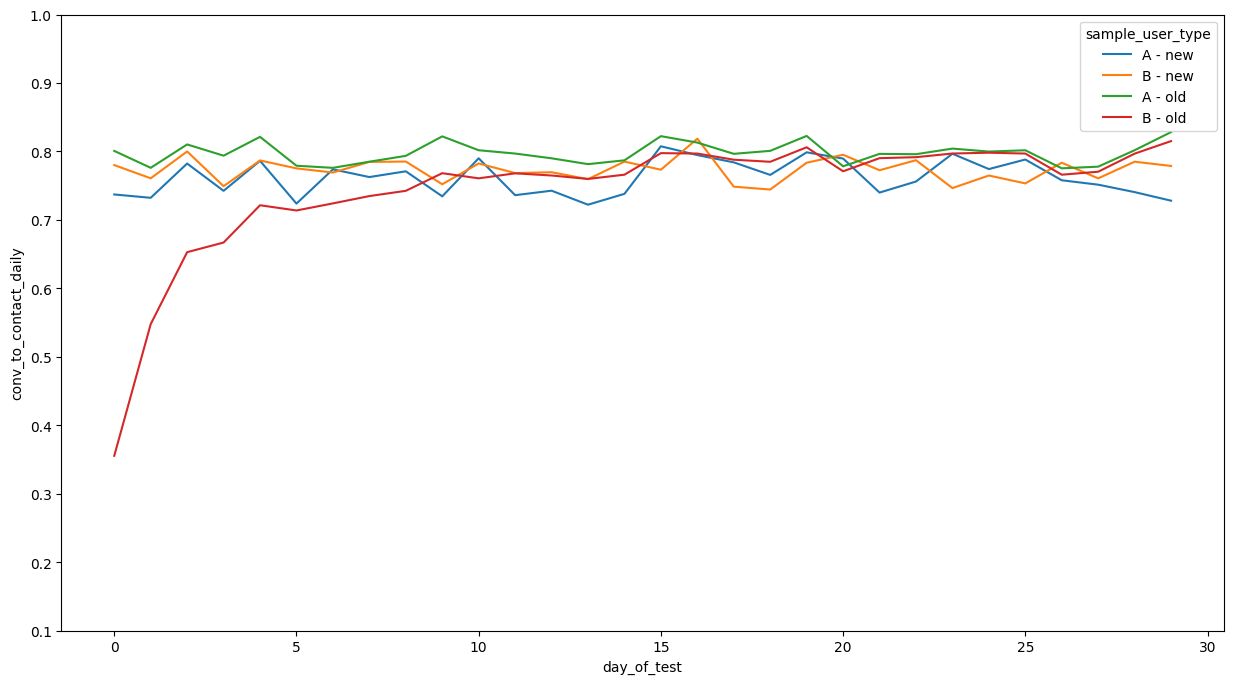

In [ ]:
# создадим колонку сколько дней прошло с момента первого захода
# это нужно для определения того является ли пользователь новым или уже вернувшимся
new_df['retention_day'] = (pd.to_datetime(new_df['date_in_app']) - pd.to_datetime(new_df['first_date_in_app'])).dt.days

# в зависимости от retention дня в приложении укажем на каждый день кто был новым (new), а кто вернувшимся (old)
# примем за правило, что если пользователь пришел не больше чем 3 суток назад, то мы считаем его новым пользователем
new_df['user_status'] = (new_df['retention_day'] < 3).astype('int')
new_df['user_status'] = np.where(new_df['user_status']== 1, 'new', 'old')

# создадим агрегированную таблицу. На ее основании будем визуализировать нужные нам метрики эффекта
ab_agg = new_df.groupby(['day_of_test', 'user_status', 'sample_type']).agg({'conv_to_contact_daily':'mean'}).reset_index()

# покажем, как выглядят конверсии для наших 4 групп
plt.figure(figsize = (15, 8))
ab_agg['sample_user_type'] = ab_agg['sample_type'] + ' - ' + ab_agg['user_status']
sns.lineplot(data=ab_agg, x='day_of_test', y='conv_to_contact_daily', hue='sample_user_type')
plt.ylim(0.1, 1)
plt.show()


In [ ]:
agg_1 = new_df.groupby(['day_of_test', 'user_status'], group_keys = False).agg({'user_id':'count'}).reset_index()
agg_2 = new_df.groupby(['day_of_test'], group_keys = False).agg({'user_id':'count'}).reset_index()
agg_3 = agg_1.merge(agg_2, on = 'day_of_test')
agg_3['prop_new_group'] = agg_3['user_id_x']/agg_3['user_id_y']
new_users_prop_df = agg_3[agg_3['user_status'] == 'new']['prop_new_group']
new_group_avg_prop = new_users_prop_df.mean()

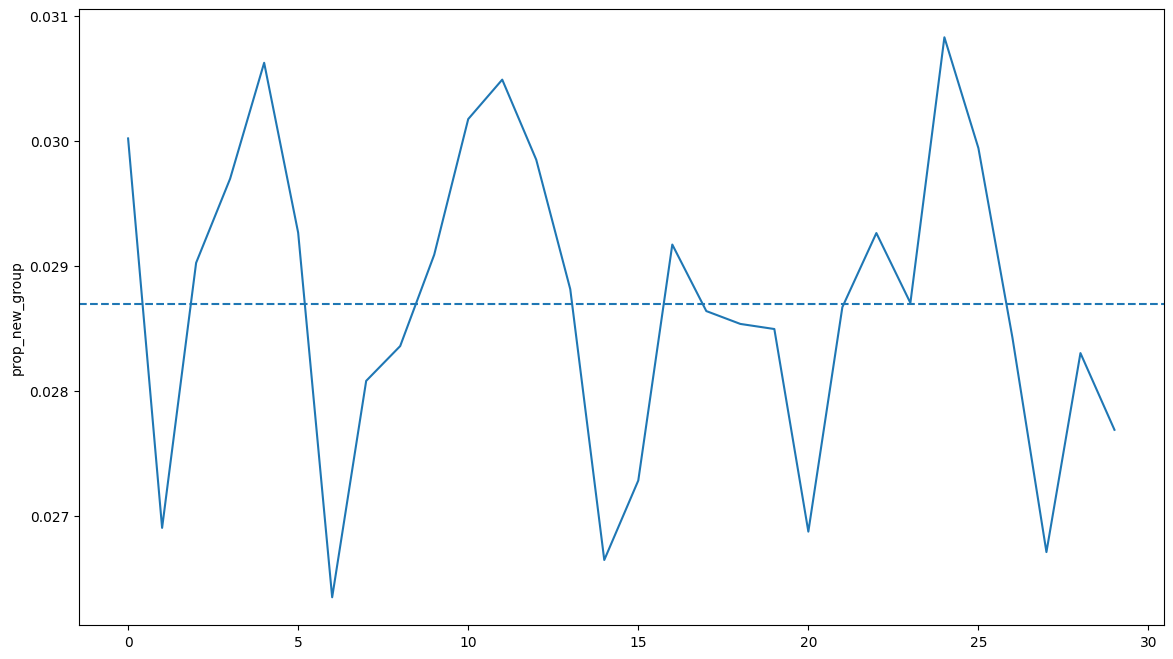

In [ ]:
plt.figure(figsize = (14,8))
sns.lineplot(y = agg_3[agg_3['user_status'] == 'new']['prop_new_group'], x = np.arange(len(agg_3[agg_3['user_status'] == 'new']['prop_new_group'])))
plt.axhline(y = new_group_avg_prop, linestyle = '--')


In [ ]:
## - Эффект между А и Б группой для "старых" пользователей
## - Эффект между А и Б группой для новых пользователей
## - Разницу между эффектом в "старой" группе и эффектом в "новой" группе

crt_no_effect = ab_agg.pivot(index='day_of_test', columns='sample_user_type', values='conv_to_contact_daily').reset_index()
crt_no_effect['conv_delta_new'] = round((crt_no_effect['B - new'] / crt_no_effect['A - new'] - 1), 3)
crt_no_effect['conv_delta_old'] = round((crt_no_effect['B - old'] / crt_no_effect['A - old'] - 1), 3)
crt_no_effect['conv_deltas_delta'] = round((crt_no_effect['conv_delta_new'] - crt_no_effect['conv_delta_old']), 3)


In [ ]:
day3_delta = crt_no_effect.loc[crt_no_effect['day_of_test']==2,'conv_deltas_delta'].values
print('Абсолютная разница эффекта между "старой" и "новой" группами на 3 день теста составила', abs(day3_delta))

Абсолютная разница эффекта между "старой" и "новой" группами на 3 день теста составила [0.217]


In [ ]:
crt_no_effect

sample_user_type,day_of_test,A - new,A - old,B - new,B - old,conv_delta_new,conv_delta_old,conv_deltas_delta
0,0,0.737179,0.800818,0.780120,0.355381,0.058,-0.556,0.614
1,1,0.732308,0.776104,0.760797,0.547733,0.039,-0.294,0.333
2,2,0.782369,0.810289,0.800000,0.652883,0.023,-0.194,0.217
3,3,0.742500,0.793848,0.749271,0.666943,0.009,-0.160,0.169
4,4,0.786325,0.821354,0.786885,0.721421,0.001,-0.122,0.123
5,5,0.723861,0.779166,0.775281,0.713795,0.071,-0.084,0.155
6,6,0.773885,0.776071,0.769231,0.724132,-0.006,-0.067,0.061
7,7,0.762611,0.785058,0.784768,0.734836,0.029,-0.064,0.093
8,8,0.771014,0.793592,0.785276,0.742510,0.018,-0.064,0.082
9,9,0.734463,0.822057,0.752089,0.768267,0.024,-0.065,0.089
